In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# CONFIGURATION: Map your column names here
# ==========================================
COLS = {
    # Geography & Time
    'state': 'state',           # Your State Column
    'district': 'district',     # Your District Column
    'year': 'year',             # Year Column (e.g., 2015, 2020)
    
    # Demographics
    'gender': 'gender',         # Gender Column
    'female_val': 2,            # Value used for Female in 'gender' col (e.g., 2 or 'F')
    'male_val': 1,              # Value used for Male in 'gender' col (e.g., 1 or 'M')
    
    # Tech Variables (0/1 Dummies)
    'internet': 'internet access',
    'mobile': 'mobile access',
    
    # Labor Variables (0/1 Dummies)
    'lfpr': 'in labor force',
    'employed': 'employed',
    'salaried': 'employed_salaried',
    
    # NEW Outcomes (0/1 Dummies or Continuous)
    'dv': 'domestic_violence',      # Placeholder: Map to your DV variable
    'nutrition': 'breastfeeding'    # Placeholder: Map to your Nutrition variable
}

# Define the years for analysis
YEAR_1 = 2015
YEAR_2 = 2020

def plot_parallel_trends(df, outcome_col, title, ylabel):
    """
    Generates the Parallel Trends graph.
    """
    # Check if variable exists in DF to avoid errors if data is missing
    if outcome_col not in df.columns:
        print(f"Skipping plot for {outcome_col} (Variable not found)")
        return

    plt.figure(figsize=(10, 6))
    
    # Calculate means for Treated vs Control over time
    trend_data = df.groupby(['treatment_group', COLS['year']])[outcome_col].mean().reset_index()
    
    # Plot
    sns.lineplot(data=trend_data, x=COLS['year'], y=outcome_col, hue='treatment_group', 
                 style='treatment_group', markers=True, dashes=False, linewidth=2.5)
    
    plt.title(f"Parallel Trends Check: {title}", fontsize=14)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.xticks([YEAR_1, YEAR_2])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Group')
    plt.tight_layout()
    plt.show()

def run_correlation_analysis(df, x_col, y_col, title):
    """
    Plots a correlation scatterplot with regression line and runs a simple OLS regression.
    Uses the latest year (Year 2) for cross-sectional correlation.
    """
    print(f"\n--- Analyzing Correlation: {title} ---")
    
    # Filter for latest year and ensure columns exist
    if y_col not in df.columns:
        print(f"Skipping analysis for {y_col} (Variable not found)")
        return

    data_for_plot = df[df[COLS['year']] == YEAR_2].dropna(subset=[x_col, y_col])
    
    if data_for_plot.empty:
        print("No data available for this correlation.")
        return

    # 1. Plot
    plt.figure(figsize=(8, 6))
    sns.regplot(data=data_for_plot, x=x_col, y=y_col, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f"Correlation (Year {YEAR_2}): {title}")
    plt.xlabel("Digital Gender Gap (Male - Female)")
    plt.ylabel(y_col)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    # 2. Regression
    # Clean column names for formula API (remove spaces if any)
    formula_y = y_col.replace(" ", "_")
    formula_x = x_col.replace(" ", "_")
    
    # Rename columns in a temp df to ensure formula works
    temp_df = data_for_plot.rename(columns={y_col: formula_y, x_col: formula_x})
    
    model = smf.ols(f"{formula_y} ~ {formula_x}", data=temp_df).fit()
    print(f"Regression Results ({title}):")
    print(model.summary().tables[1])
    print("-" * 30)

def analyze_digital_gender_gap(df):
    """
    Main pipeline to process data, define treatment, and run DiD analysis.
    """
    
    # --- STEP 1: AGGREGATE TO DISTRICT LEVEL ---
    print("Aggregating individual data to district level...")
    
    # 1a. Tech Access
    tech_agg = df.groupby([COLS['state'], COLS['district'], COLS['year'], COLS['gender']])[[COLS['internet'], COLS['mobile']]].mean().reset_index()
    
    male_tech = tech_agg[tech_agg[COLS['gender']] == COLS['male_val']].set_index([COLS['district'], COLS['year']])
    female_tech = tech_agg[tech_agg[COLS['gender']] == COLS['female_val']].set_index([COLS['district'], COLS['year']])
    
    # 1b. Outcomes (Women Only)
    women_df = df[df[COLS['gender']] == COLS['female_val']]
    
    # Identify which outcome columns are actually in the provided dataframe
    possible_outcomes = [COLS['lfpr'], COLS['employed'], COLS['salaried'], COLS['dv'], COLS['nutrition']]
    available_outcomes = [c for c in possible_outcomes if c in df.columns]
    
    labor_agg = women_df.groupby([COLS['state'], COLS['district'], COLS['year']])[available_outcomes].mean().reset_index()
    labor_agg.set_index([COLS['district'], COLS['year']], inplace=True)

    # --- STEP 2: CALCULATE DIGITAL GENDER GAP (DGG) ---
    dist_df = pd.DataFrame()
    dist_df['dgg_internet'] = male_tech[COLS['internet']] - female_tech[COLS['internet']]
    dist_df['dgg_mobile'] = male_tech[COLS['mobile']] - female_tech[COLS['mobile']]
    
    dist_df = dist_df.join(labor_agg).reset_index()
    
    state_map = df.groupby(COLS['district'])[COLS['state']].first()
    dist_df[COLS['state']] = dist_df[COLS['district']].map(state_map)

    # --- STEP 3: CALCULATE CHANGE & DEFINE TREATMENT ---
    print("Calculating Delta DGG and defining treatment groups...")
    
    dgg_pivot = dist_df.pivot(index=COLS['district'], columns=COLS['year'], values='dgg_internet')
    dgg_pivot['delta_dgg'] = dgg_pivot[YEAR_2] - dgg_pivot[YEAR_1]
    
    dgg_pivot['treatment_group'] = np.nan
    dgg_pivot.loc[dgg_pivot['delta_dgg'] <= -0.08, 'treatment_group'] = 'Treated'
    dgg_pivot.loc[dgg_pivot['delta_dgg'] >= 0.00, 'treatment_group'] = 'Control'
    
    clean_districts = dgg_pivot.dropna(subset=['treatment_group'])
    final_df = dist_df.merge(clean_districts[['treatment_group', 'delta_dgg']], on=COLS['district'], how='inner')
    
    # --- STEP 4: BASELINE BALANCE CHECK ---
    print(f"\n--- Baseline Balance Check ({YEAR_1}) ---")
    baseline_df = final_df[final_df[COLS['year']] == YEAR_1]
    
    balance_vars = [c for c in [COLS['lfpr'], COLS['employed'], 'dgg_internet'] if c in final_df.columns]
    
    results = []
    for var in balance_vars:
        treated = baseline_df[baseline_df['treatment_group'] == 'Treated'][var].dropna()
        control = baseline_df[baseline_df['treatment_group'] == 'Control'][var].dropna()
        
        if len(treated) > 0 and len(control) > 0:
            t_stat, p_val = stats.ttest_ind(treated, control, equal_var=False)
            results.append({
                'Variable': var,
                'Treated Mean': treated.mean(),
                'Control Mean': control.mean(),
                'Diff': treated.mean() - control.mean(),
                'P-Value': p_val
            })
        
    if results:
        balance_table = pd.DataFrame(results)
        print(balance_table)
    else:
        balance_table = pd.DataFrame()
        print("Insufficient data for balance check.")

    # --- STEP 5: VISUALIZATION (PARALLEL TRENDS) ---
    print("\n--- Generating Parallel Trends Plots ---")
    if COLS['lfpr'] in final_df.columns:
        plot_parallel_trends(final_df, COLS['lfpr'], "Women's LFPR Over Time", "LFPR")
    if COLS['dv'] in final_df.columns:
        plot_parallel_trends(final_df, COLS['dv'], "Domestic Violence Over Time", "Domestic Violence Rate")

    # --- STEP 6: CORRELATIONS & SIMPLE REGRESSIONS (New Request) ---
    # We correlate Outcome vs Internet Gap (dgg_internet)
    
    run_correlation_analysis(final_df, 'dgg_internet', COLS['lfpr'], "LFPR vs Internet Gap")
    run_correlation_analysis(final_df, 'dgg_internet', COLS['dv'], "Domestic Violence vs Internet Gap")
    run_correlation_analysis(final_df, 'dgg_internet', COLS['nutrition'], "Child Nutrition vs Internet Gap")

    # --- STEP 7: DiD REGRESSIONS ---
    print("\n--- Running DiD Regressions ---")
    
    final_df['Post'] = (final_df[COLS['year']] == YEAR_2).astype(int)
    final_df['Treated_Dummy'] = (final_df['treatment_group'] == 'Treated').astype(int)
    final_df['DiD_Interaction'] = final_df['Post'] * final_df['Treated_Dummy']
    
    if COLS['lfpr'] in final_df.columns:
        reg_df = final_df.rename(columns={COLS['lfpr']: 'LFPR', COLS['state']: 'State_Code'})
        
        # Model 1: Basic DiD
        model_basic = smf.ols("LFPR ~ Treated_Dummy + Post + DiD_Interaction", data=reg_df).fit(cov_type='cluster', cov_kwds={'groups': reg_df[COLS['district']]})
        
        # Model 2: State FE
        model_fe = smf.ols("LFPR ~ Treated_Dummy + Post + DiD_Interaction + C(State_Code)", data=reg_df).fit(cov_type='cluster', cov_kwds={'groups': reg_df[COLS['district']]})
        
        print("\nModel 1 (Basic DiD) Results:")
        print(model_basic.summary().tables[1])
        print("\nModel 2 (State FE) Results:")
        print(model_fe.summary().tables[1])
        
        return final_df, balance_table, model_fe
    
    return final_df, balance_table, None

--- Loading Datasets ---
--- Merging Data ---
Matched Districts: 618
     merge_key  gap_2018  male_own_18  fem_own_18         State_ID  gap_2021  \
0  rajnandgaon  0.492143     0.861899    0.369756     chhattisgarh  0.495022   
1      rajouri  0.462907     0.985632    0.522725  jammu & kashmir  0.244650   
2     mandsaur  0.413248     0.922031    0.508783   madhya pradesh  0.585742   
3        jammu  0.408858     0.976643    0.567785  jammu & kashmir  0.102667   
4       kamrup  0.408467     0.949965    0.541497            assam  0.377290   

   delta_gap  State_Code  LFPR_2019  Employed_2019  
0   0.002878          22        114             22  
1  -0.218257           1         65              8  
2   0.172494          23         37             13  
3  -0.306192           1        180             66  
4  -0.031177          18         45             21  

 ANALYSIS RESULTS 


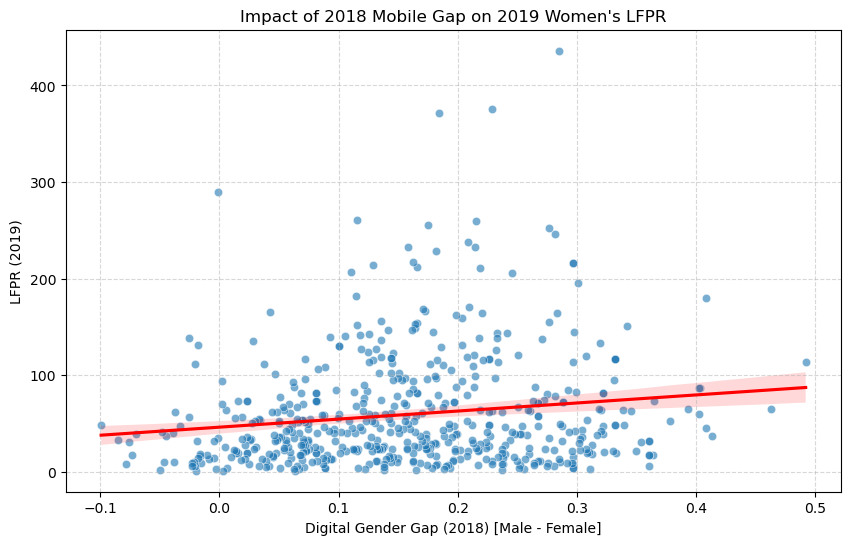


--- Model A: Lagged Effect (gap_18 -> lfpr_19) ---
R-Squared: 0.413
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              39.0653     11.665      3.349      0.001      16.203      61.928
C(State_Code)[T.2]     85.7345     24.497      3.500      0.000      37.721     133.748
C(State_Code)[T.3]      0.3781     14.026      0.027      0.978     -27.111      27.868
C(State_Code)[T.5]      9.0081     13.855      0.650      0.516     -18.148      36.164
C(State_Code)[T.6]    -17.3290     12.074     -1.435      0.151     -40.993       6.335
C(State_Code)[T.8]     15.8106     13.628      1.160      0.246     -10.899      42.520
C(State_Code)[T.9]    -14.0250     11.432     -1.227      0.220     -36.431       8.381
C(State_Code)[T.10]   -30.4903     11.271     -2.705      0.007     -52.580      -8.400
C(State_Code)[T.11]   108.3860     20.308      5.33

In [32]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. DATA LOADING & CONFIGURATION
# ==========================================

# File Paths (Update these if your folder structure differs)
FILE_2018 = r"data\dist+div_4.csv"                # T1 Digital Data
FILE_2021 = r"data\divide_5.csv"                  # T2 Digital Data
FILE_PLFS = r"data\plfs_lakshay_19-20_processed.csv" # Outcome Data

def clean_district_name(name):
    """
    Standardizes district names to maximize merge success.
    Removes spaces, makes lowercase, removes common suffixes.
    """
    if pd.isna(name): return ""
    name = str(name).lower().strip()
    name = name.replace(" district", "").replace("dt.", "")
    name = name.replace("&", "and").replace("-", " ")
    return name

def process_data():
    print("--- Loading Datasets ---")
    
    # ----------------------------------
    # A. Process 2018 Data (Pre-Period)
    # ----------------------------------
    # Columns: district, men_mobile_own, women_mobile_own, etc.
    df_18 = pd.read_csv(FILE_2018)
    
    # Create Standard Key
    df_18['merge_key'] = df_18['district'].apply(clean_district_name)
    
    # Calculate 2018 Gap (Male - Female)
    # Note: Ensure these are percentages (0-100) or proportions (0-1). We normalize to Proportions (0-1).
    df_18['gap_2018'] = df_18['men_mobile_own'] - df_18['women_mobile_own']
    
    # Keep only necessary columns
    df_18 = df_18[['merge_key', 'gap_2018', 'men_mobile_own', 'women_mobile_own']].rename(
        columns={'men_mobile_own': 'male_own_18', 'women_mobile_own': 'fem_own_18'}
    )

    # ----------------------------------
    # B. Process 2020-21 Data (Post-Period)
    # ----------------------------------
    # Columns: state_id, smdist, prop_mobile_own_m, prop_mobile_own_f
    df_21 = pd.read_csv(FILE_2021)
    
    # Create Standard Key
    df_21['merge_key'] = df_21['smdist'].apply(clean_district_name)
    
    # Calculate 2021 Gap
    df_21['gap_2021'] = df_21['prop_mobile_own_m'] - df_21['prop_mobile_own_f']
    
    # Keep only necessary columns
    df_21 = df_21[['merge_key', 'state_id', 'gap_2021']].rename(columns={'state_id': 'State_ID'})

    # ----------------------------------
    # C. Process PLFS 2019-20 (Outcome)
    # ----------------------------------
    # Columns: State_Code, District, in_labour_force, Employed
    df_plfs = pd.read_csv(FILE_PLFS)
    
    # Create Standard Key
    df_plfs['merge_key'] = df_plfs['District'].apply(clean_district_name)
    
    # Define Outcomes
    # Assuming 'in_labour_force' is a Rate (LFPR). If it is a raw count, 
    # you must divide by population. We assume it is the rate here.
    df_plfs = df_plfs.rename(columns={
        'in_labour_force': 'LFPR_2019',
        'Employed': 'Employed_2019'
    })
    
    # Select cols
    df_plfs = df_plfs[['merge_key', 'State_Code', 'LFPR_2019', 'Employed_2019']]

    # ----------------------------------
    # D. MERGE ALL
    # ----------------------------------
    print("--- Merging Data ---")
    
    # Merge 18 and 21 (Digital Evolution)
    tech_df = pd.merge(df_18, df_21, on='merge_key', how='inner')
    
    # Calculate the CHANGE in Gap (Did it improve?)
    # Negative value = Gap reduced (Improvement)
    tech_df['delta_gap'] = tech_df['gap_2021'] - tech_df['gap_2018']
    
    # Merge with Outcomes (PLFS 19)
    final_df = pd.merge(tech_df, df_plfs, on='merge_key', how='inner')
    
    print(f"Matched Districts: {len(final_df)}")
    print(final_df.head())
    
    return final_df

def run_analysis(df):
    """
    Since we only have 1 year of outcome, we run a Lagged Regression.
    Hypothesis: Does the Digital Gap in 2018 predict Labor Force Participation in 2019?
    """
    print("\n==========================================")
    print(" ANALYSIS RESULTS ")
    print("==========================================")

    # --- 1. CORRELATION VISUALIZATION ---
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='gap_2018', y='LFPR_2019', alpha=0.6)
    sns.regplot(data=df, x='gap_2018', y='LFPR_2019', scatter=False, color='red')
    plt.title("Impact of 2018 Mobile Gap on 2019 Women's LFPR")
    plt.xlabel("Digital Gender Gap (2018) [Male - Female]")
    plt.ylabel("LFPR (2019)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # --- 2. REGRESSION MODELS ---
    
    # Clean data for statsmodels
    reg_df = df.dropna(subset=['LFPR_2019', 'gap_2018', 'State_Code'])
    
    # MODEL A: Lagged Level Effect
    # "Does a high gender gap in 2018 associate with lower LFPR next year?"
    # We control for State Fixed Effects using C(State_Code)
    formula_a = "LFPR_2019 ~ gap_2018 + C(State_Code)"
    
    model_a = smf.ols(formula_a, data=reg_df).fit(cov_type='HC1') # Heteroskedasticity Robust
    
    print("\n--- Model A: Lagged Effect (gap_18 -> lfpr_19) ---")
    print(f"R-Squared: {model_a.rsquared:.3f}")
    print(model_a.summary().tables[1])
    
    # MODEL B: Dynamic Effect (Change in Gap)
    # "Did districts that closed the gap fast (negative delta) see better outcomes?"
    # Note: This is trickier because Delta includes 2021 data (post-outcome), 
    # but it proxies for the "trend" of digitization in that district.
    formula_b = "LFPR_2019 ~ delta_gap + C(State_Code)"
    
    model_b = smf.ols(formula_b, data=reg_df).fit(cov_type='HC1')
    
    print("\n--- Model B: Change Effect (delta_gap -> lfpr_19) ---")
    print(f"R-Squared: {model_b.rsquared:.3f}")
    print(model_b.summary().tables[1])

# ==========================================
# EXECUTION
# ==========================================
if __name__ == "__main__":
    # 1. Process and Merge
    master_df = process_data()
    
    # 2. Run Regressions
    if not master_df.empty:
        run_analysis(master_df)
    else:
        print("Error: Merged dataframe is empty. Check district name spellings.")

N = 623 districts matched.

--- Summary of Groups ---
                  delta_dgg       LFPR
treated_quartile                      
0                  0.430738  38.688406
1                 -0.059132  84.862319


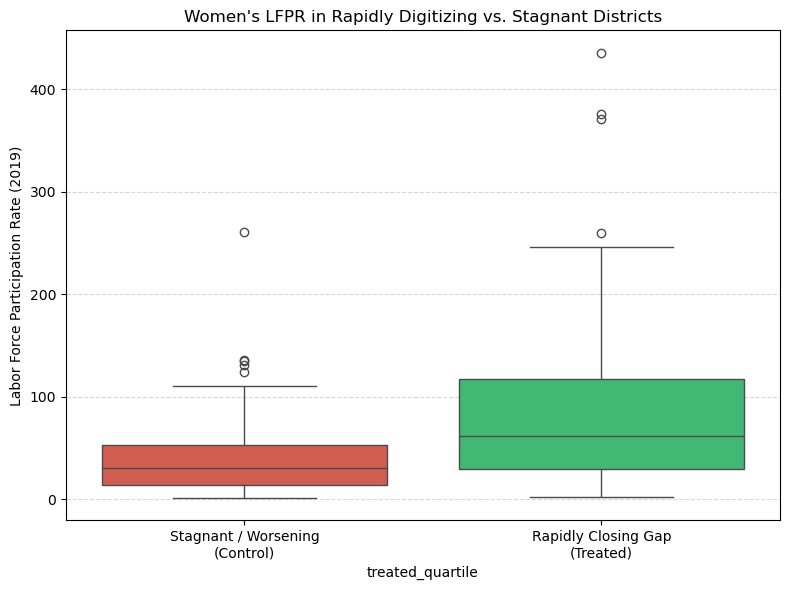

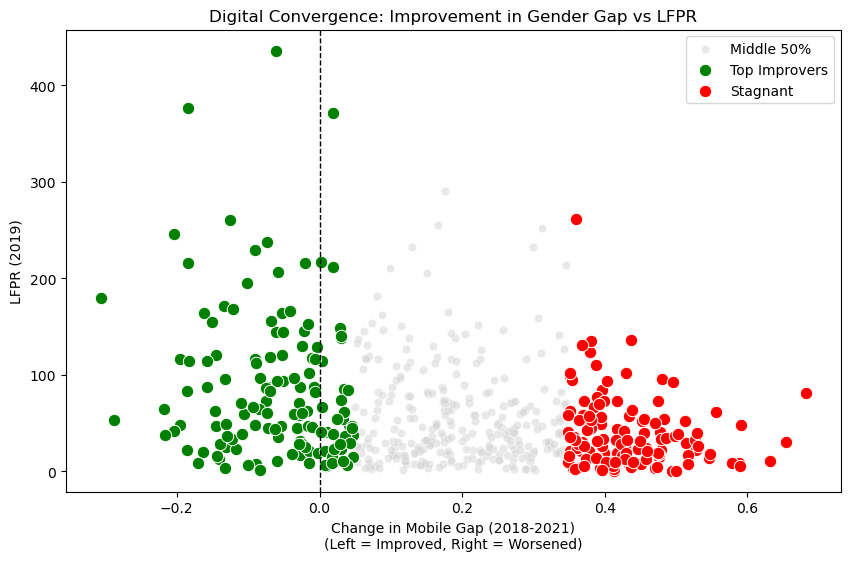


 FINAL REGRESSION RESULTS (Q1 vs Q4) 
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            59.2147     15.639      3.786      0.000      28.562      89.867
C(State_ID)[T.2]     98.8647     34.374      2.876      0.004      31.492     166.237
C(State_ID)[T.3]     -0.8985     19.723     -0.046      0.964     -39.555      37.758
C(State_ID)[T.5]      0.2647     16.745      0.016      0.987     -32.556      33.085
C(State_ID)[T.6]    -26.3349     16.630     -1.584      0.113     -58.928       6.258
C(State_ID)[T.8]    -11.3269     17.408     -0.651      0.515     -45.445      22.792
C(State_ID)[T.9]    -36.0781     15.503     -2.327      0.020     -66.463      -5.693
C(State_ID)[T.10]   -47.6160     15.703     -3.032      0.002     -78.393     -16.839
C(State_ID)[T.11]    94.5647     28.656      3.300      0.001      38.401     150.729
C(State_ID)[T.1

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. DATA PREPARATION (Same mapping as before)
# ==========================================
FILE_2018 = r"data\dist+div_4.csv"
FILE_2021 = r"data\divide_5.csv"
FILE_PLFS = r"data\plfs_lakshay_19-20_processed.csv"

def clean_district_name(name):
    if pd.isna(name): return ""
    name = str(name).lower().strip()
    for x in [" district", "dt.", "&", "-", " "]:
        name = name.replace(x, "") if x not in ["&", "-"] else name.replace(x, "and")
    return name

def get_merged_data():
    # Load & Clean (Condensed for brevity)
    d18 = pd.read_csv(FILE_2018)
    d18['merge_key'] = d18['district'].apply(clean_district_name)
    d18['gap_18'] = d18['men_mobile_own'] - d18['women_mobile_own']
    
    d21 = pd.read_csv(FILE_2021)
    d21['merge_key'] = d21['smdist'].apply(clean_district_name)
    d21['gap_21'] = d21['prop_mobile_own_m'] - d21['prop_mobile_own_f']
    
    plfs = pd.read_csv(FILE_PLFS)
    plfs['merge_key'] = plfs['District'].apply(clean_district_name)
    plfs = plfs.rename(columns={'in_labour_force': 'LFPR', 'State_Code': 'State_ID'})
    
    # Merge
    df = d18[['merge_key', 'gap_18']].merge(d21[['merge_key', 'gap_21']], on='merge_key')
    df = df.merge(plfs[['merge_key', 'LFPR', 'State_ID']], on='merge_key')
    
    # Calculate Delta (Negative is GOOD, it means gap shrunk)
    df['delta_dgg'] = df['gap_21'] - df['gap_18']
    return df

# ==========================================
# 2. QUARTILE & REGRESSION LOGIC
# ==========================================

df = get_merged_data()
print(f"N = {len(df)} districts matched.")

# --- STEP A: Generate Quartiles (The 'xtile' command) ---
# We cut data into 4 buckets based on improvement.
# Note: Since 'negative' delta is good, the "Smallest" numbers are actually the "Best" improvement.
# Labels: Q1 (Best Improvement/Most Negative) to Q4 (Worst/Worsened).
df['quartile_rank'] = pd.qcut(df['delta_dgg'], q=4, labels=['Top Improvers', 'Moderate Imp', 'Moderate Worse', 'Stagnant/Worse'])

# --- STEP B: Define Treatment (Top 25% vs Bottom 25%) ---
# Top Improvers (Most negative change) vs Stagnant (Most positive/least negative change)
# Note: Check your data's sign direction! 
# If delta is (2021 - 2018), then -0.20 is a BIG improvement.
# ... [Previous code remains the same] ...

# --- STEP B: Define Treatment ---
df['treated_quartile'] = np.nan
df.loc[df['quartile_rank'] == 'Top Improvers', 'treated_quartile'] = 1 
df.loc[df['quartile_rank'] == 'Stagnant/Worse', 'treated_quartile'] = 0 

# Drop the middle 50% AND create a proper copy
reg_df = df.dropna(subset=['treated_quartile']).copy()

# === FIX IS HERE: Convert float (0.0, 1.0) to integer (0, 1) ===
reg_df['treated_quartile'] = reg_df['treated_quartile'].astype(int)

print("\n--- Summary of Groups ---")
print(reg_df.groupby('treated_quartile')[['delta_dgg', 'LFPR']].mean())

# --- STEP C: VISUALS ---

# Visual 1: Boxplot
plt.figure(figsize=(8, 6))
# Note: Added hue=treated_quartile to satisfy new Seaborn requirements for palettes
sns.boxplot(data=reg_df, x='treated_quartile', y='LFPR', hue='treated_quartile', 
            palette={0: "#e74c3c", 1: "#2ecc71"}, legend=False)

plt.xticks([0, 1], ['Stagnant / Worsening\n(Control)', 'Rapidly Closing Gap\n(Treated)'])
plt.title("Women's LFPR in Rapidly Digitizing vs. Stagnant Districts")
plt.ylabel("Labor Force Participation Rate (2019)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Visual 2: Scatter (Unchanged, but ensures colors map correctly)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='delta_dgg', y='LFPR', color='lightgray', alpha=0.5, label='Middle 50%')
sns.scatterplot(data=reg_df[reg_df['treated_quartile']==1], x='delta_dgg', y='LFPR', color='green', s=80, label='Top Improvers')
sns.scatterplot(data=reg_df[reg_df['treated_quartile']==0], x='delta_dgg', y='LFPR', color='red', s=80, label='Stagnant')

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("Digital Convergence: Improvement in Gender Gap vs LFPR")
plt.xlabel("Change in Mobile Gap (2018-2021)\n(Left = Improved, Right = Worsened)")
plt.ylabel("LFPR (2019)")
plt.legend()
plt.show()

# --- STEP D: FINAL REGRESSION ---
# (Model code remains exactly the same)
formula = "LFPR ~ treated_quartile + C(State_ID)"
model = smf.ols(formula, data=reg_df).fit(cov_type='HC1')

print("\n==========================================")
print(" FINAL REGRESSION RESULTS (Q1 vs Q4) ")
print("==========================================")
print(model.summary().tables[1])

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Generate dummy data
data = np.random.randn(100).cumsum() 

# Run ADF Test
result = adfuller(data)
p_value = result[1]

print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("Result: Stationary (Reject H0)")
else:
    print("Result: Non-Stationary (Fail to Reject H0)")

ADF Statistic: -0.9604146057162937
P-Value: 0.7674270841155257
Result: Non-Stationary (Fail to Reject H0)


In [3]:
from statsmodels.tsa.stattools import grangercausalitytests

# Generate two related time series
df = pd.DataFrame(data=np.random.randint(0, 100, size=(100, 2)), columns=['Y', 'X'])

# Run Granger Causality Test (checks lags 1 to 4)
# The function returns a dictionary; we extract p-values for the "ssr_chi2test"
max_lags = 4
results = grangercausalitytests(df[['Y', 'X']], maxlag=max_lags, verbose=False)

for lag in range(1, max_lags + 1):
    # Accessing the p-value for the Chi-squared test at this specific lag
    p_val = results[lag][0]['ssr_chi2test'][1]
    print(f"Lag {lag}: p-value = {p_val:.4f}")

Lag 1: p-value = 0.2823
Lag 2: p-value = 0.3010
Lag 3: p-value = 0.5992
Lag 4: p-value = 0.7718


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [4]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Generate dummy residuals (random noise)
residuals = np.random.normal(0, 1, 100)

# Run Ljung-Box test
# return_df=True gives a clean pandas DataFrame with p-values
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

print(lb_test)

      lb_stat  lb_pvalue
10  16.873912   0.077201


In [5]:
from statsmodels.tsa.arima.model import ARIMA

# Fit a simple ARIMA model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit()

# Print the full summary table (includes P>|z|)
print(model_fit.summary())

# Access specific p-values programmatically
print("\nSpecific P-values:")
print(model_fit.pvalues)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -144.443
Date:                Fri, 21 Nov 2025   AIC                            294.886
Time:                        15:25:14   BIC                            302.672
Sample:                             0   HQIC                           298.036
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7301      0.376      1.943      0.052      -0.006       1.467
ma.L1         -0.6097      0.448     -1.360      0.174      -1.489       0.269
sigma2         1.0829      0.162      6.680      0.0

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



--- Time Series Significance (Paired T-Test) ---
Mean Gap 2018: 0.1581
Mean Gap 2021: 0.3469
Change (Delta): 0.1888
P-Value: nan
CONCLUSION: No significant change observed over time.


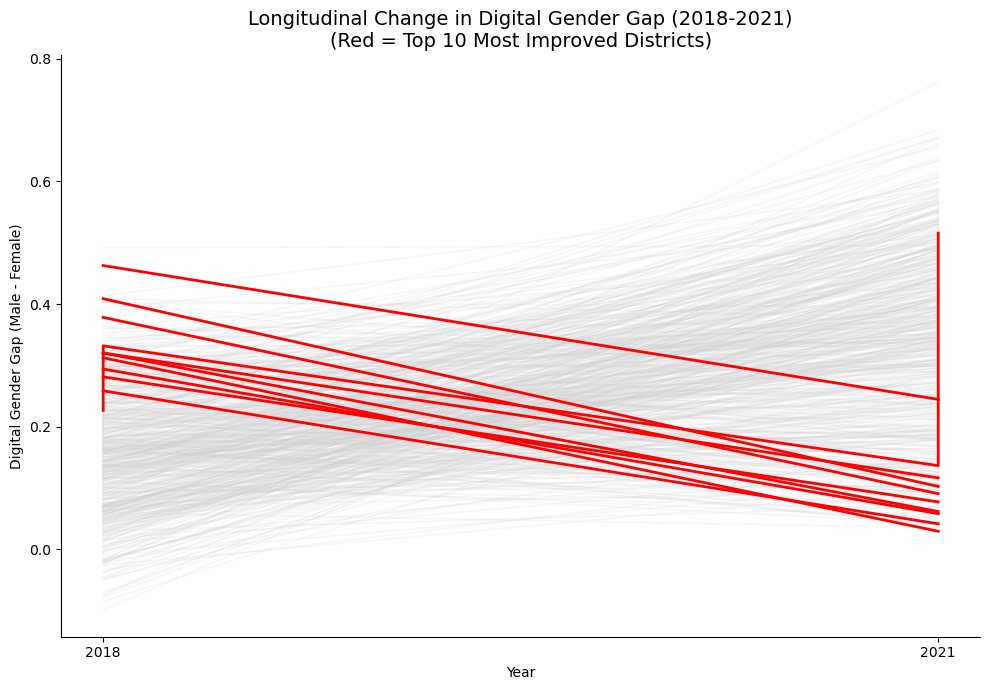

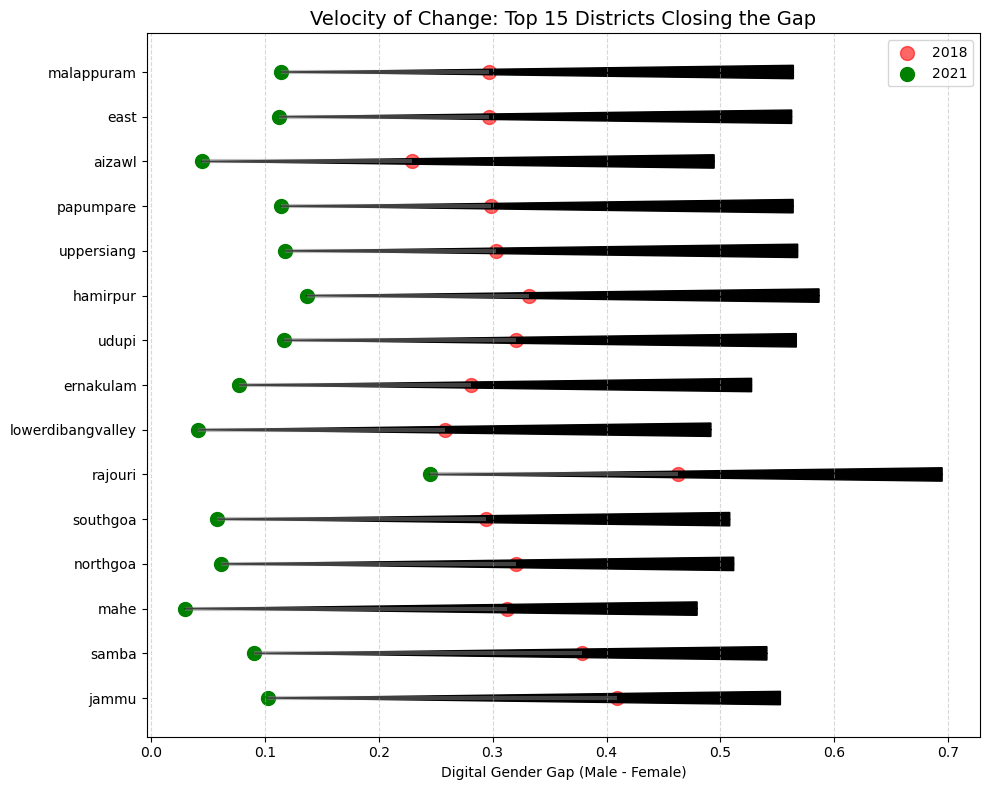

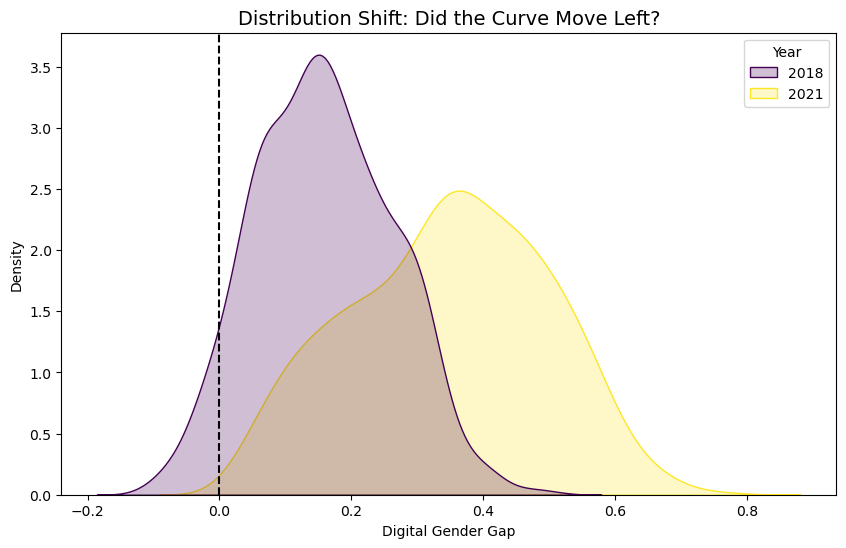

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ==========================================
# 1. DATA LOAD (Using your existing logic)
# ==========================================
FILE_2018 = r"data\dist+div_4.csv"
FILE_2021 = r"data\divide_5.csv"
FILE_PLFS = r"data\plfs_lakshay_19-20_processed.csv"

def clean_district_name(name):
    if pd.isna(name): return ""
    name = str(name).lower().strip()
    for x in [" district", "dt.", "&", "-", " "]:
        name = name.replace(x, "") if x not in ["&", "-"] else name.replace(x, "and")
    return name

def get_data():
    # Load & Clean
    d18 = pd.read_csv(FILE_2018)
    d18['merge_key'] = d18['district'].apply(clean_district_name)
    d18['gap_18'] = d18['men_mobile_own'] - d18['women_mobile_own']
    
    d21 = pd.read_csv(FILE_2021)
    d21['merge_key'] = d21['smdist'].apply(clean_district_name)
    d21['gap_21'] = d21['prop_mobile_own_m'] - d21['prop_mobile_own_f']
    
    # Merge only the digital data for Time Series Analysis
    df = d18[['merge_key', 'gap_18']].merge(d21[['merge_key', 'gap_21']], on='merge_key')
    
    # Calculate Delta
    df['delta_dgg'] = df['gap_21'] - df['gap_18']
    return df

df = get_data()

# ==========================================
# 2. STATISTICAL TEST: IS THE CHANGE SIGNIFICANT?
# ==========================================
# We use a Paired T-Test to see if the "Time" factor is significant.
t_stat, p_val = stats.ttest_rel(df['gap_18'], df['gap_21'])

print("\n--- Time Series Significance (Paired T-Test) ---")
print(f"Mean Gap 2018: {df['gap_18'].mean():.4f}")
print(f"Mean Gap 2021: {df['gap_21'].mean():.4f}")
print(f"Change (Delta): {df['gap_21'].mean() - df['gap_18'].mean():.4f}")
print(f"P-Value: {p_val:.5e}")

if p_val < 0.05:
    print("CONCLUSION: The change in Digital Gap over time is Statistically Significant.")
else:
    print("CONCLUSION: No significant change observed over time.")

# ==========================================
# 3. RESHAPE FOR TIME PLOTTING
# ==========================================
# Convert from Wide (gap_18, gap_21) to Long (Year, Gap)
df_long = pd.melt(df, id_vars=['merge_key', 'delta_dgg'], 
                  value_vars=['gap_18', 'gap_21'],
                  var_name='Year_Label', value_name='Digital_Gap')

# Clean Year Labels
df_long['Year'] = df_long['Year_Label'].map({'gap_18': 2018, 'gap_21': 2021})

# Identify Top Improvers for highlighting
top_improvers = df.sort_values('delta_dgg').head(10)['merge_key'].tolist()

# ==========================================
# 4. VISUALIZATIONS
# ==========================================

# --- PLOT A: The "Slope Chart" (Tracking Trajectories) ---
# 


plt.figure(figsize=(10, 7))

# Plot ALL districts as faint gray lines (Context)
sns.lineplot(data=df_long, x='Year', y='Digital_Gap', units='merge_key', 
             estimator=None, color='lightgray', alpha=0.2, linewidth=1)

# Highlight TOP 10 IMPROVERS in Red
highlight_data = df_long[df_long['merge_key'].isin(top_improvers)]
sns.lineplot(data=highlight_data, x='Year', y='Digital_Gap', units='merge_key',
             estimator=None, color='red', alpha=1, linewidth=2)

plt.xticks([2018, 2021])
plt.title(f"Longitudinal Change in Digital Gender Gap (2018-2021)\n(Red = Top 10 Most Improved Districts)", fontsize=14)
plt.ylabel("Digital Gender Gap (Male - Female)")
plt.grid(False)
sns.despine()
plt.tight_layout()
plt.show()

# --- PLOT B: The "Arrow Plot" (Velocity of Change) ---
# 
# This shows the magnitude of the jump for the top districts
# --- PLOT B: The "Arrow Plot" (Velocity of Change) ---
# FIXED CODE

subset = df.sort_values('delta_dgg').head(15).copy() # Get top 15

# 1. Create a numerical index (0 to 14) to use as the Y-coordinate
subset['y_pos'] = range(len(subset))

plt.figure(figsize=(10, 8))

# 2. Plot Horizontal Lines using the numerical y_pos
plt.hlines(y=subset['y_pos'], xmin=subset['gap_18'], xmax=subset['gap_21'], 
           color='gray', alpha=0.5, linewidth=3)

# 3. Plot Start/End Points using y_pos
plt.scatter(subset['gap_18'], subset['y_pos'], color='red', alpha=0.6, s=100, label='2018')
plt.scatter(subset['gap_21'], subset['y_pos'], color='green', alpha=1, s=100, label='2021')

# 4. Plot Arrows using y_pos (Now it's a number, so plt.arrow works)
for i, row in subset.iterrows():
    plt.arrow(x=row['gap_18'], y=row['y_pos'], 
              dx=(row['gap_21'] - row['gap_18']), dy=0, 
              length_includes_head=True, head_width=0.3, color='black')

# 5. Map the numerical Y-axis back to District Names
plt.yticks(ticks=subset['y_pos'], labels=subset['merge_key'])

plt.title("Velocity of Change: Top 15 Districts Closing the Gap", fontsize=14)
plt.xlabel("Digital Gender Gap (Male - Female)")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- PLOT C: KDE Distribution Shift (Macro View) ---
# 
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_long, x='Digital_Gap', hue='Year', fill=True, palette='viridis', common_norm=False)
plt.title("Distribution Shift: Did the Curve Move Left?", fontsize=14)
plt.xlabel("Digital Gender Gap")
plt.axvline(0, color='black', linestyle='--') # Equality Line
plt.show()